# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html		SeriesTemporais.Rproj	VECM_Infla.py
Benchmark.ipynb		tabs			VECM_TxPropria.html
Benchmark.pdf		tese_Lucas.xls		VECM_TxPropria.ipynb
Benchmark.Rmd		Teste.ipynb		VECM_TxPropria_media.ipynb
Clean-checkpoint.ipynb	VECM_Infla.html		VECM_TxPropria.pdf
Clean.ipynb		VECM_Infla.ipynb	VECM_TxPropria.py
figs			VECM_Infla_media.ipynb
RespostaGabriel.docx	VECM_Infla.pdf


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
#start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

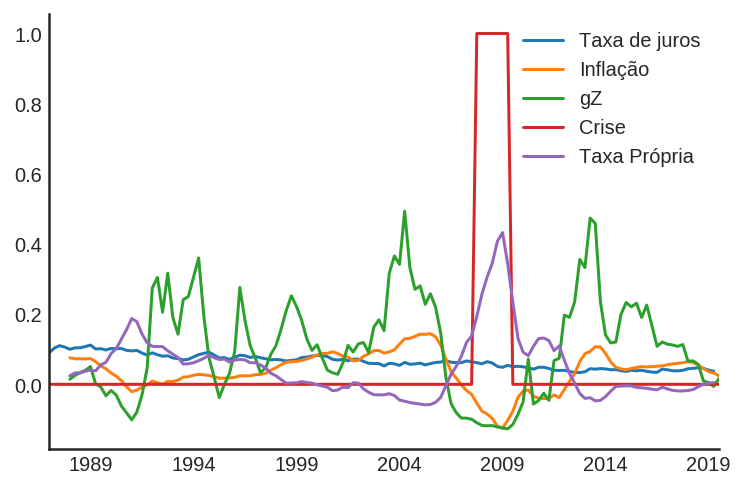

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
1988-06-30,0.1040,0.072736,0.025430,0,0.032525,0.007931,0.010722,-0.002865,0.0041
1988-09-30,0.1042,0.072867,0.033724,0,0.032601,0.000076,0.008294,0.000131,0.0002
1988-12-31,0.1077,0.072268,0.039976,0,0.037428,0.004827,0.006252,-0.000599,0.0035
1989-03-31,0.1119,0.073632,0.050665,0,0.040773,0.003345,0.010689,0.001365,0.0042
1989-06-30,0.1007,0.064730,0.001108,0,0.038373,-0.002400,-0.049557,-0.008903,-0.0112


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df = df.resample('M').last()
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df = df.resample('Q').last()

df["Inflação"] = df["Preço dos imóveis"].pct_change(4) # Warning: 4
df['gZ'] = df["Investimento residencial"].pct_change(4) # Warning: 4
df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1

df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])
#df['Inflação'], *_ = yeojohnson(df['Inflação'])
df['gZ'], *_ = yeojohnson(df['gZ'])

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv")


df.to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        #'data',
        'invRes',
        'preco',
        'juros',
        'infla',
        'taxap',
        'gz',
        'crise',
          ], 
         )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.head()

# Funções

## Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS série em nível')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS série em primeira difenrença')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF série em nível')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF série em primeira diferença')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS série em nível')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS série em primeira diferença')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Teste de Cointegração Engel-Granger e de Johansen

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=8):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=0.05,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=1) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i}, Rank = {result.rank}')
        print(10*'=')

## Análise de resíduos: Ljung-Box e Box-Pierce

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')

# Teste de quebra estrutural

In [8]:
%%R -i df
library(strucchange)
library(urca)
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- ts(data = df, start = c(1987,01), frequency = 4)
bp_ts <- breakpoints(Juros ~ 1, data=df)
print("Testando quebra estrutural para Taxa de juros das hipotecas")
print(summary(bp_ts))

bp_ts <- breakpoints(gZ ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa de crescimento dos imóveis")
print(summary(bp_ts))

bp_ts <- breakpoints(TaxaP ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa Própria")
print(summary(bp_ts))

bp_ts <- breakpoints(Infla ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Inflação")
print(summary(bp_ts))

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



[1] "Testando quebra estrutural para Taxa de juros das hipotecas"

	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = Juros ~ 1, data = df)

Breakpoints at observation number:
                      
m = 1            78   
m = 2            67 85
m = 3   18       67 85
m = 4   18 36    67 85
m = 5   18 36 54 73 91

Corresponding to breakdates:
                                               
m = 1                           2006(2)        
m = 2                           2003(3) 2008(1)
m = 3   1991(2)                 2003(3) 2008(1)
m = 4   1991(2) 1995(4)         2003(3) 2008(1)
m = 5   1991(2) 1995(4) 2000(2) 2005(1) 2009(3)

Fit:
                                                   
m   0       1       2       3       4       5      
RSS   6.608   5.957   4.278   4.278   4.278   4.278
BIC  -3.113  -6.411 -38.155 -28.499 -18.842  -9.186
[1] "========================="
[1] "Testando quebra estrutural para Taxa de crescimento dos imÃ³veis"

	 Optimal (m+1)-segment part

Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]

# Teste de raíz unitária

## Investimento residencial ($g_Z$)

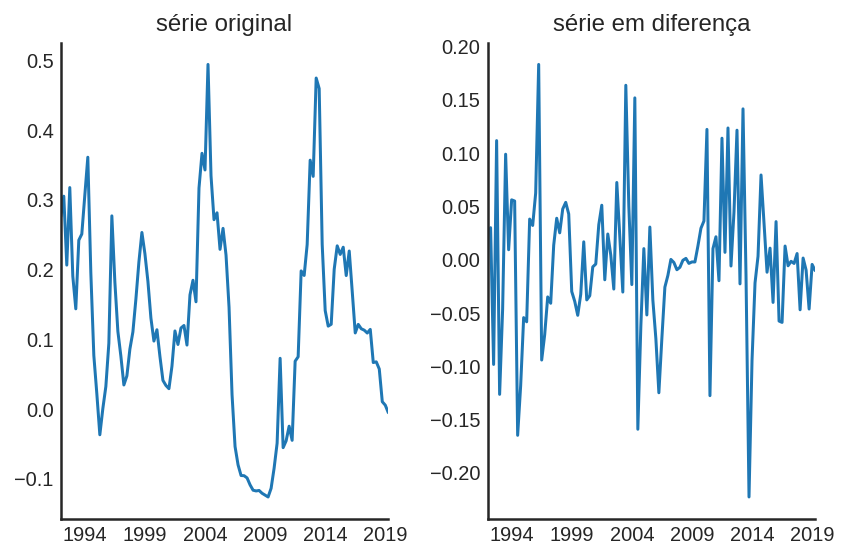

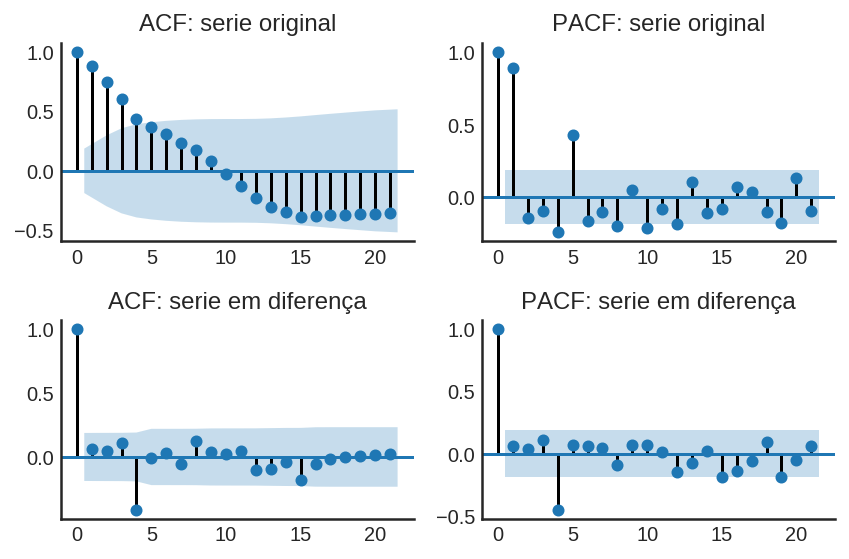


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -3.206
P-value                         0.838
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.727
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.406
P-value 

In [10]:
testes_raiz(df=df['gZ'], original_trend='c', diff_trend='c')

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

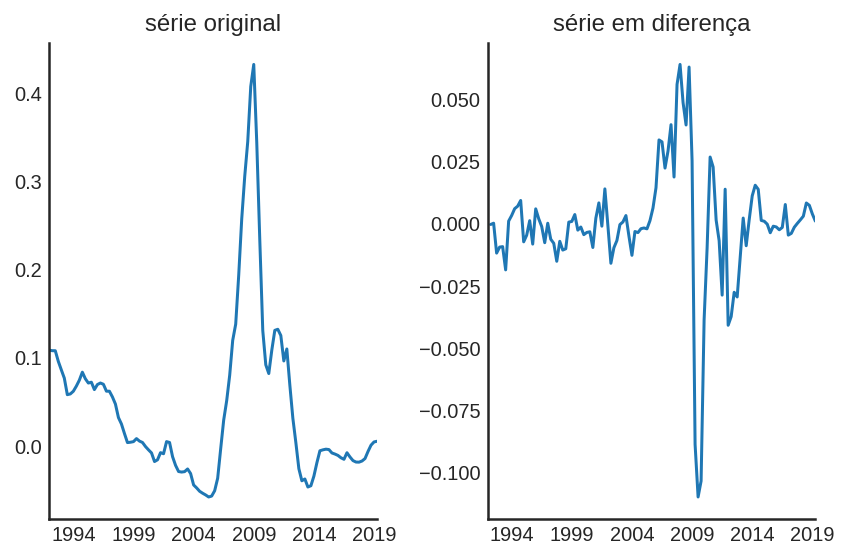

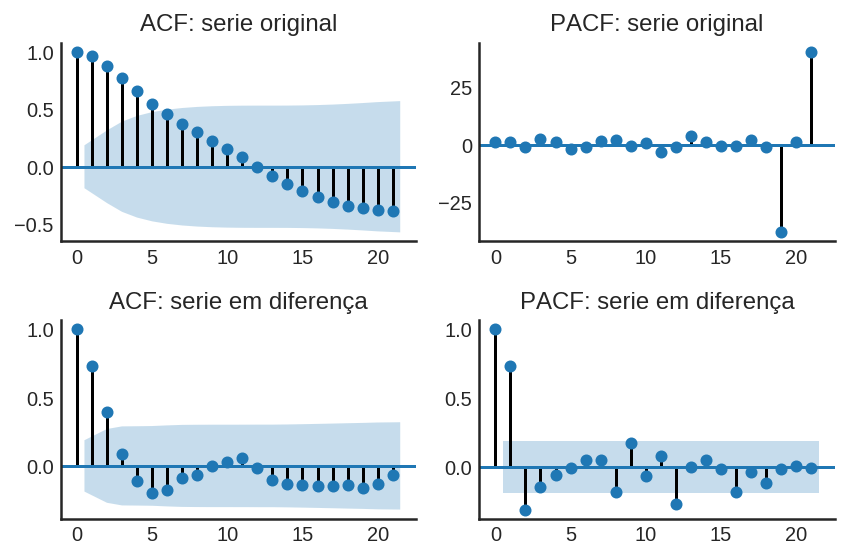


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.224
P-value                         0.227
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.121
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.709
P-value 

In [11]:
testes_raiz(df['Taxa Própria'], original_trend='c', diff_trend='c')

**Conclusão:** Será tomada em primeira diferença.

## Inflação

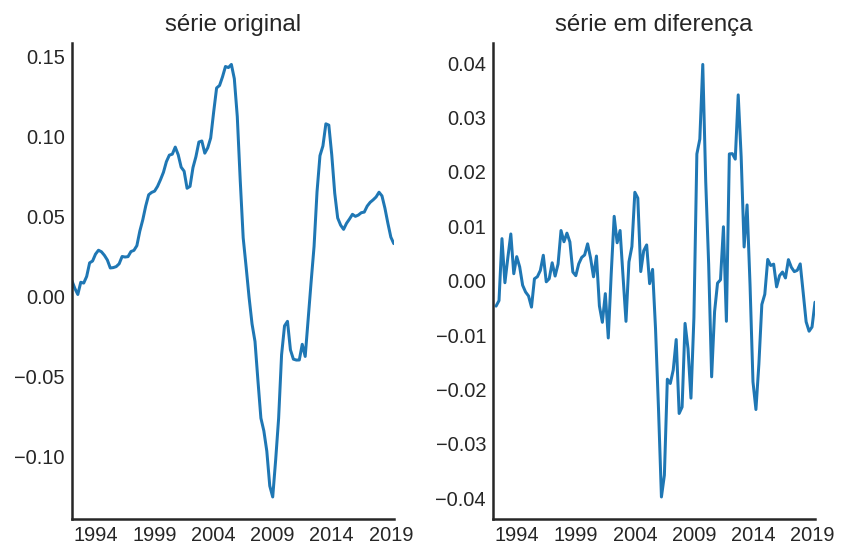

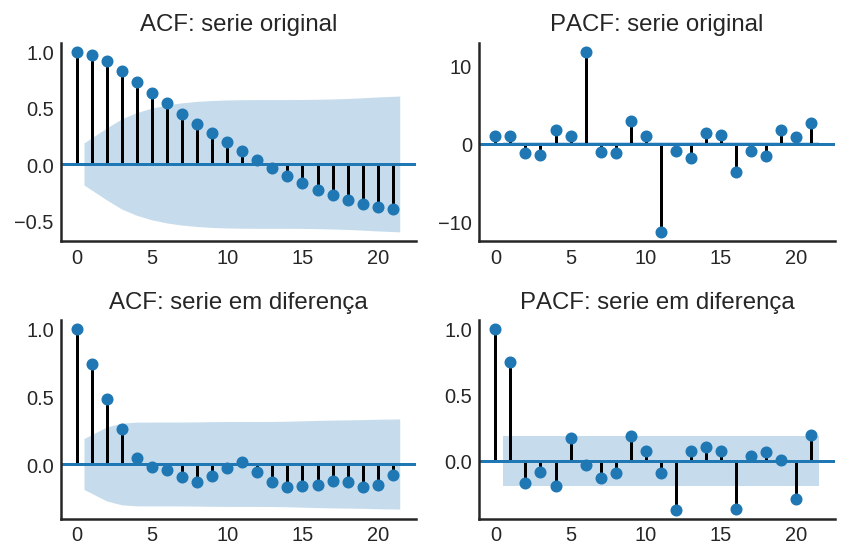


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -5.551
P-value                         0.003
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -4.650
P-value                         0.081
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.125
P-value 

In [12]:
testes_raiz(df['Inflação'], original_trend='c', diff_trend='c')

## Taxa de juros das hipotecas

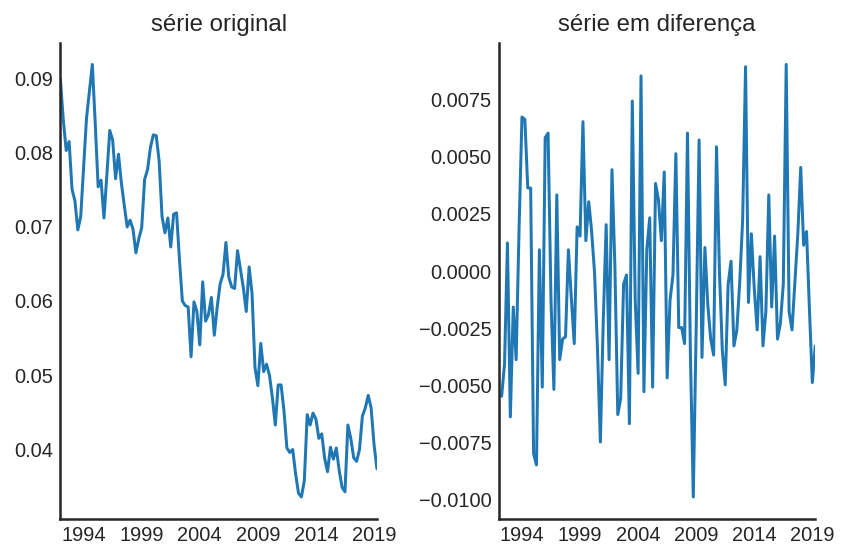

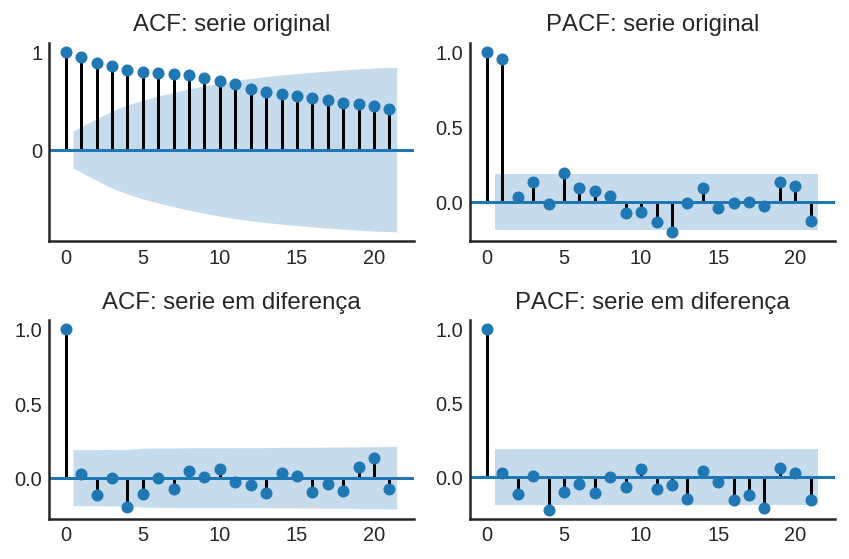


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.494
P-value                         0.215
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -8.144
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [13]:
testes_raiz(df['Taxa de juros'], original_trend='ct', diff_trend='c')

# Cointegração

## $g_Z$ e Taxa Própria

In [14]:
print("Ordem do VAR\n")

model = VAR(
    df[["gZ", 'Taxa Própria']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -9.099      -8.991   0.0001118      -9.055
1       -12.87      -12.65   2.578e-06      -12.78
2       -13.69     -13.37*   1.137e-06     -13.56*
3       -13.72      -13.29   1.097e-06      -13.55
4       -13.75      -13.22   1.066e-06      -13.54
5      -13.80*      -13.15  1.020e-06*      -13.54
6       -13.77      -13.01   1.056e-06      -13.46
7       -13.70      -12.84   1.135e-06      -13.35
8       -13.66      -12.69   1.182e-06      -13.27
9       -13.60      -12.53   1.254e-06      -13.17
10      -13.60      -12.42   1.258e-06      -13.13
11      -13.55      -12.26   1.329e-06      -13.03
12      -13.61      -12.21   1.270e-06      -13.04
13      -13.59      -12.08   1.302e-06      -12.98
14      -13.59      -11.98   1.305e-06      -12.94
15      -13.56      -11.84   1.358e-06      -12.87
-----------------

In [15]:
testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=9)


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.249464
p-value: 0.152576
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.863356
p-value: 0.011136
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.951997
p-value: 0.031462
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.836092
p-value: 0.108961
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test stati

Testando para lag = 8 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.179184
p-value: 0.193127
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 8 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.105107
p-value: 0.401386
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          17.14          18.40
-------------------------------------
Para lag = 8, Rank = 0


## $g_Z$, Inflação e taxa de juros

In [16]:
print("Ordem do VAR\n")

model = VAR(
    df[["gZ", 'Inflação', "Taxa de juros"]],
)
print(model.select_order(maxlags=15, trend='ct').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.85      -20.69   8.780e-10      -20.79
1       -26.09      -25.68   4.688e-12      -25.92
2      -26.71*     -26.06*  2.519e-12*     -26.45*
3       -26.59      -25.71   2.832e-12      -26.23
4       -26.62      -25.49   2.756e-12      -26.17
5       -26.57      -25.20   2.916e-12      -26.02
6       -26.51      -24.90   3.115e-12      -25.86
7       -26.43      -24.57   3.427e-12      -25.68
8       -26.36      -24.26   3.723e-12      -25.51
9       -26.25      -23.92   4.206e-12      -25.31
10      -26.26      -23.68   4.260e-12      -25.22
11      -26.41      -23.59   3.780e-12      -25.27
12      -26.43      -23.36   3.838e-12      -25.19
13      -26.46      -23.15   3.861e-12      -25.13
14      -26.44      -22.90   4.119e-12      -25.01
15      -26.51      -22.72   4.095e-12      -24.98
-----------------

In [17]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']], maxlag=4)


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.223565
p-value: 0.060000
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.353863
p-value: 0.123697
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.980137
p-value: 0.003298
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.125149
p-value: 0.006279
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test stati

## $g_Z$ e Inflação

In [18]:
print("Ordem do VAR\n")

model = VAR(
    endog=df[["gZ", 'Inflação']],
    exog=df['Taxa de juros']
)
print(model.select_order(maxlags=15, trend='ct').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.58      -10.42   2.546e-05      -10.51
1       -14.67      -14.40   4.266e-07      -14.56
2       -15.28     -14.91*   2.307e-07     -15.13*
3       -15.26      -14.78   2.363e-07      -15.06
4       -15.28      -14.68   2.326e-07      -15.04
5      -15.36*      -14.66  2.144e-07*      -15.08
6       -15.33      -14.52   2.220e-07      -15.00
7       -15.25      -14.34   2.392e-07      -14.88
8       -15.22      -14.20   2.476e-07      -14.81
9       -15.17      -14.04   2.629e-07      -14.71
10      -15.17      -13.94   2.621e-07      -14.67
11      -15.12      -13.78   2.780e-07      -14.58
12      -15.11      -13.66   2.832e-07      -14.52
13      -15.16      -13.60   2.705e-07      -14.53
14      -15.16      -13.49   2.739e-07      -14.49
15      -15.15      -13.37   2.800e-07      -14.43
-----------------

In [19]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.226268
p-value: 0.014259
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.339394
p-value: 0.049542
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.341414
p-value: 0.139942
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.236925
p-value: 0.332869
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test stati

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.518837
p-value: 0.509854
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.371612
p-value: 0.785776
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          14.70          18.40
-------------------------------------
Para lag = 7, Rank = 0


# VECM

VECM: $g_Z$, Inflação e Juros exógeno

## Ordem do modelo

In [20]:
from statsmodels.tsa.vector_ar.vecm import select_order

det = 'cili'
#det = 'ci'
#det = 'co'
#det = 'nc'

order_vec = select_order(
    df[[
        "Inflação", 
        #"Taxa Própria", 
        "gZ"
    ]], 
    exog=df[["Taxa de juros"]],
    maxlags=15, deterministic=det)

with open('./tabs/VECM_Infla_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-14.60,-14.28,4.549e-07,-14.47
1,-15.22,-14.78*,2.463e-07,-15.04*
2,-15.19,-14.65,2.526e-07,-14.97
3,-15.21,-14.56,2.491e-07,-14.95
4,-15.30*,-14.54,2.278e-07*,-14.99
5,-15.26,-14.39,2.374e-07,-14.91
6,-15.19,-14.21,2.562e-07,-14.79
7,-15.16,-14.07,2.653e-07,-14.72
8,-15.10,-13.91,2.814e-07,-14.62
9,-15.11,-13.81,2.815e-07,-14.58


## Estimação

Det. terms outside the coint. relation & lagged endog. parameters for equation Inflação
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1          -0.1838      0.120     -1.534      0.125      -0.419       0.051
L1.Inflação     0.8643      0.105      8.227      0.000       0.658       1.070
L1.gZ          -0.0058      0.013     -0.440      0.660      -0.032       0.020
L2.Inflação    -0.2018      0.139     -1.451      0.147      -0.474       0.071
L2.gZ           0.0246      0.013      1.850      0.064      -0.001       0.051
L3.Inflação     0.0862      0.140      0.616      0.538      -0.188       0.360
L3.gZ           0.0143      0.013      1.064      0.287      -0.012       0.041
L4.Inflação    -0.1480      0.103     -1.436      0.151      -0.350       0.054
L4.gZ          -0.0017      0.013     -0.129      0.898      -0.027       0.024
Det. terms outside the coint. re

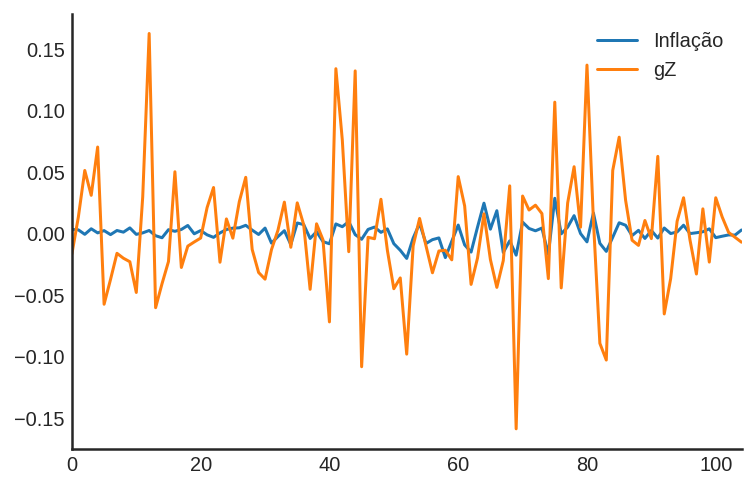

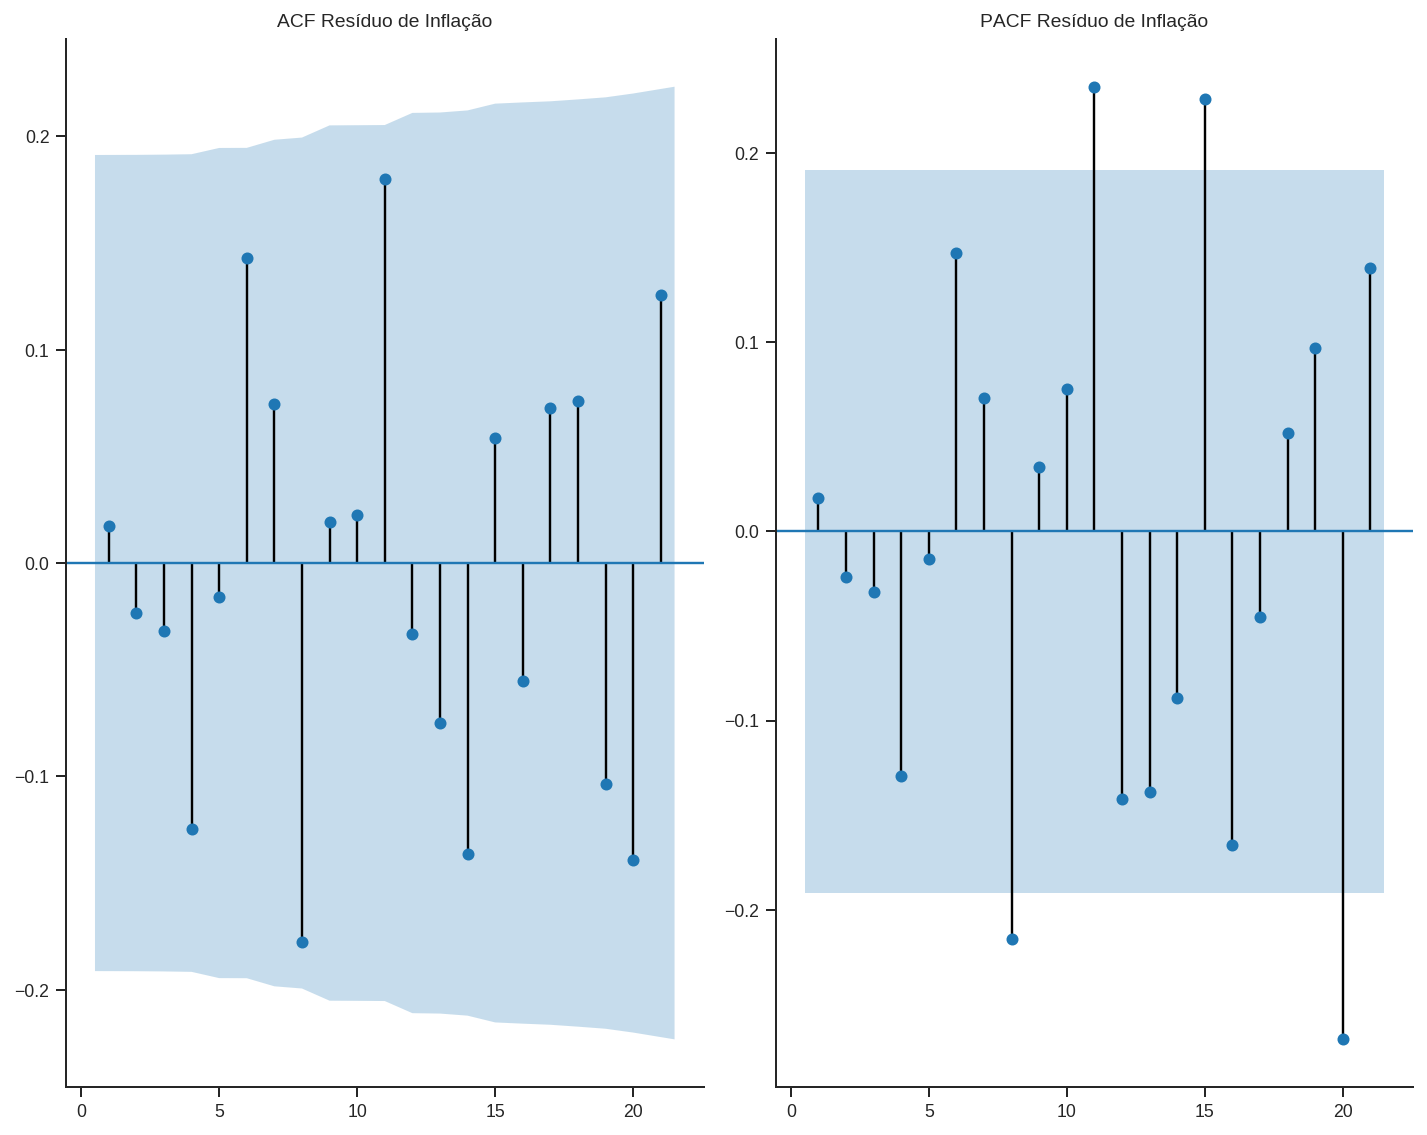

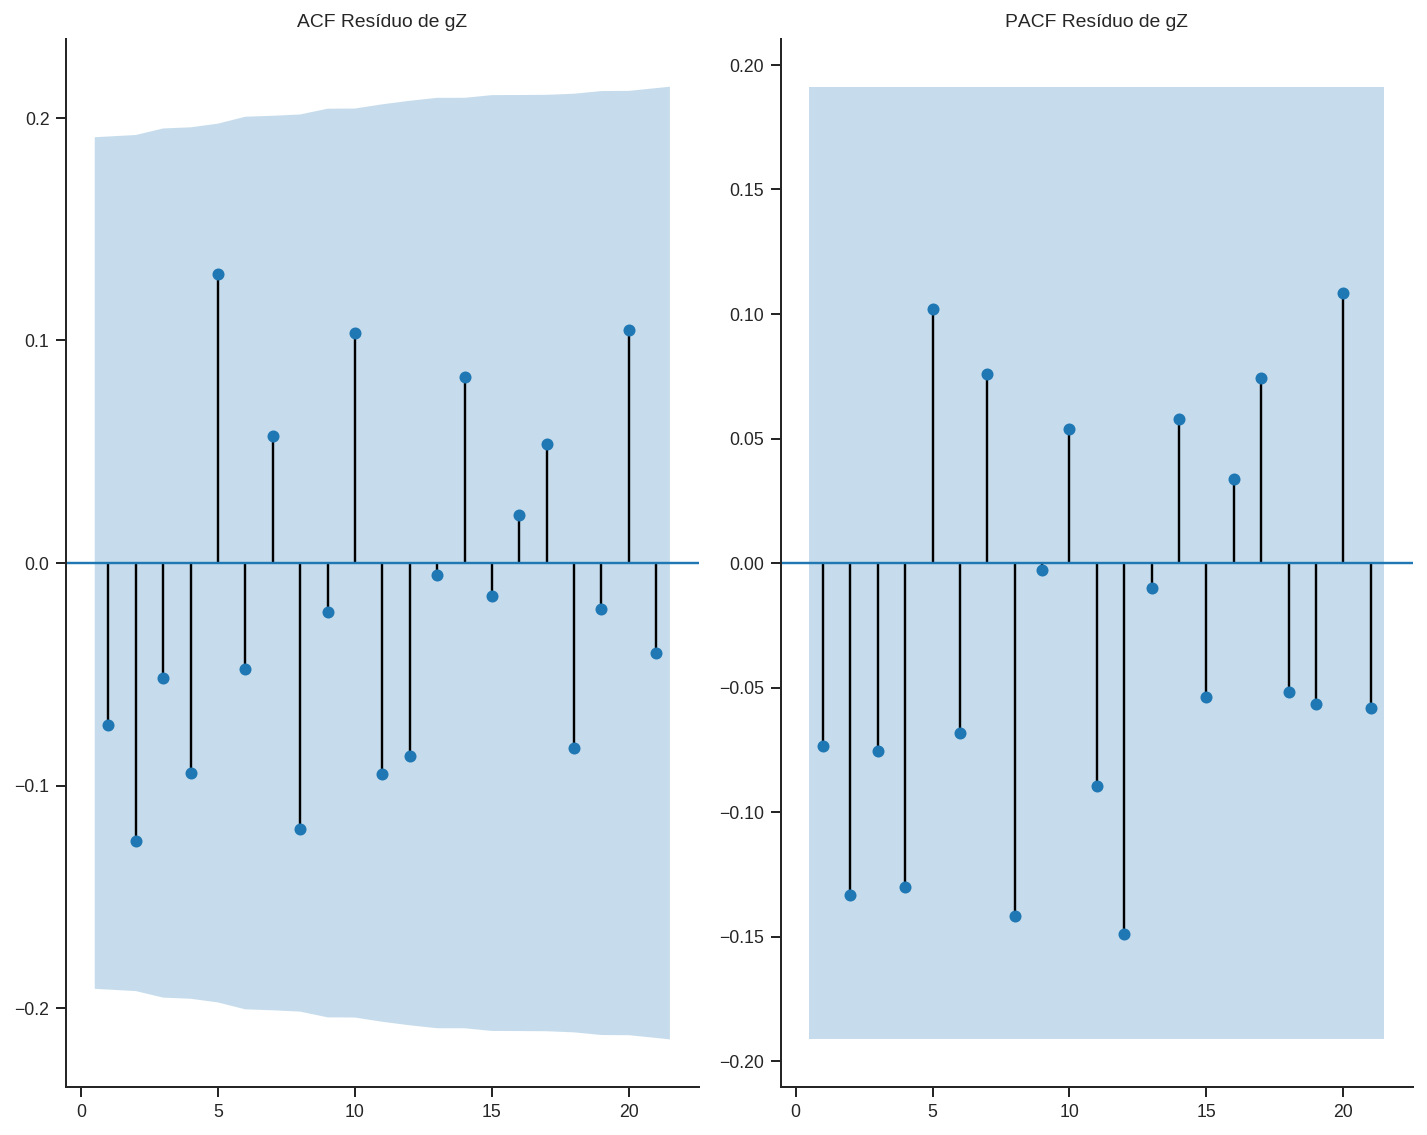

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         51.67          58.12   0.146 42
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         56.79          58.12   0.063 42
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  Fa

In [21]:
model = VECM(
    endog = df[[
        "Inflação", 
        #"Taxa Própria", 
        "gZ"
    ]], 
    exog=df[["Taxa de juros"]],
    #k_ar_diff=1,
    #k_ar_diff=2,
    #k_ar_diff=3,
    k_ar_diff=4,
    #k_ar_diff=5,
    #k_ar_diff=6,
    deterministic=det
)
results = model.fit()

with open('./tabs/VECM_Infla_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())
    
print(results.summary())

print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função impulso resposta ortogonalizada

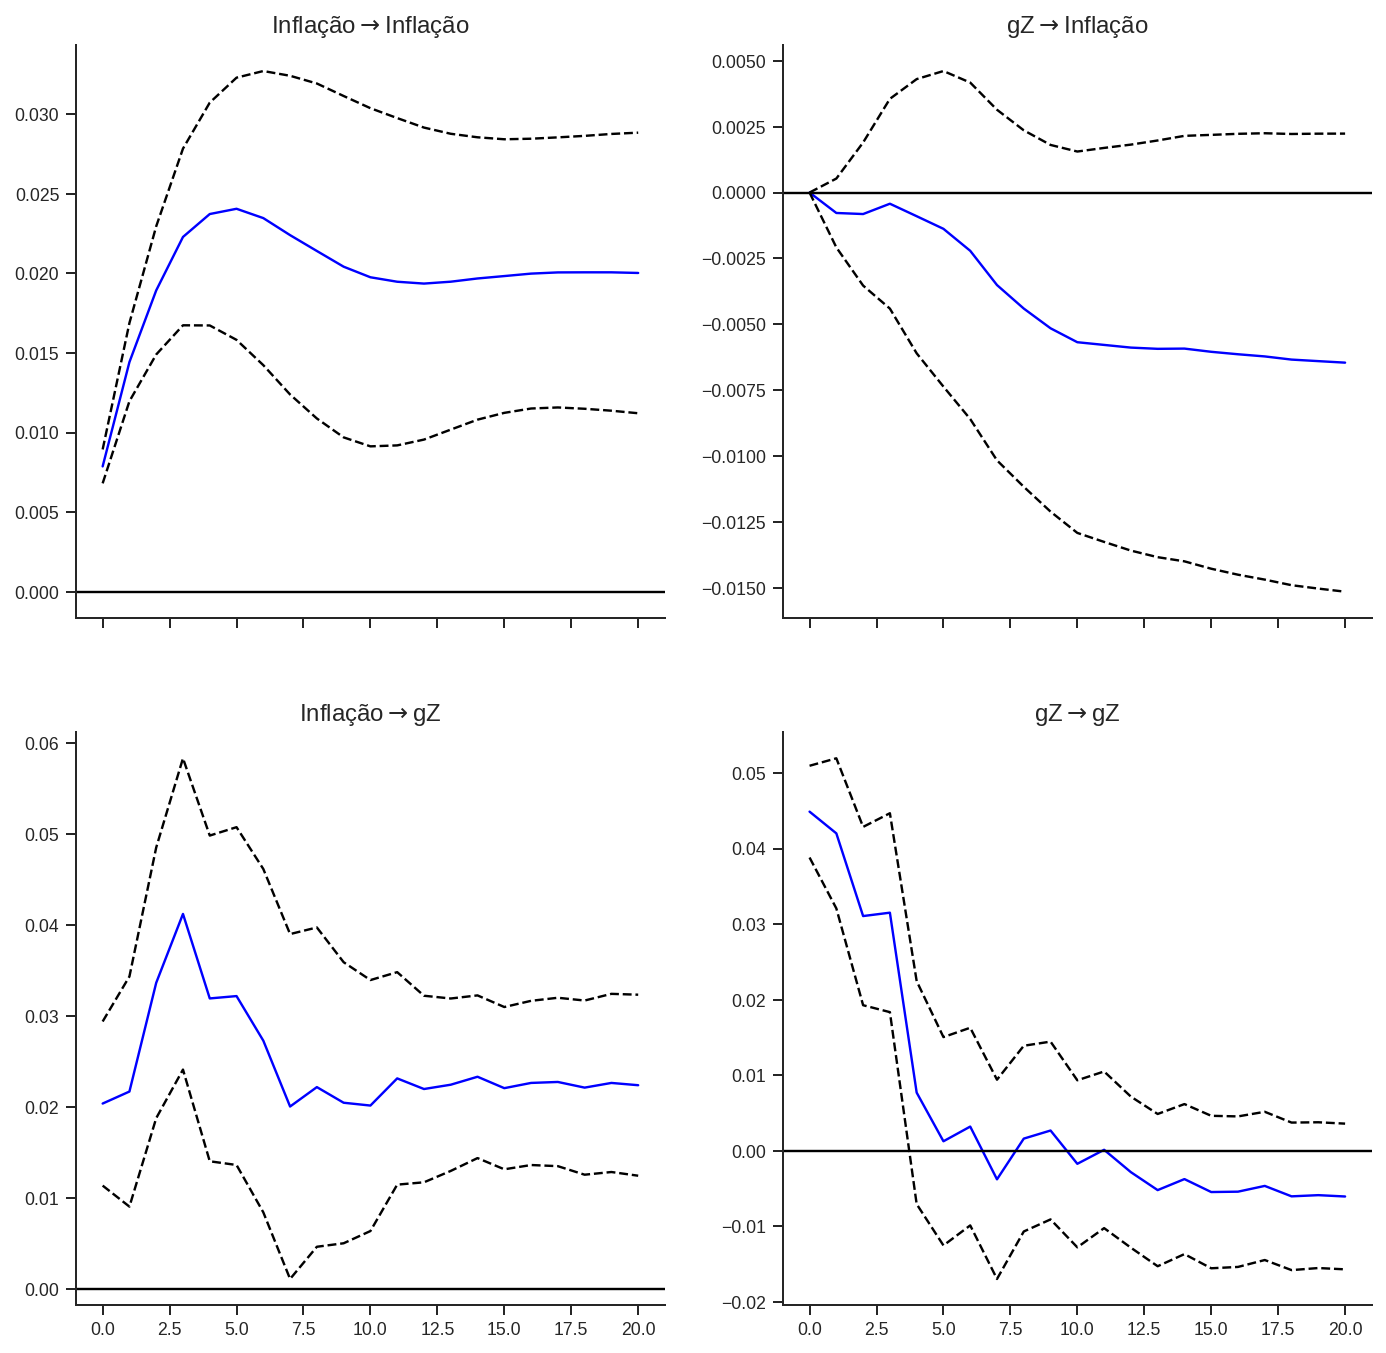

In [22]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função impulso resposta não-ortogonalizada

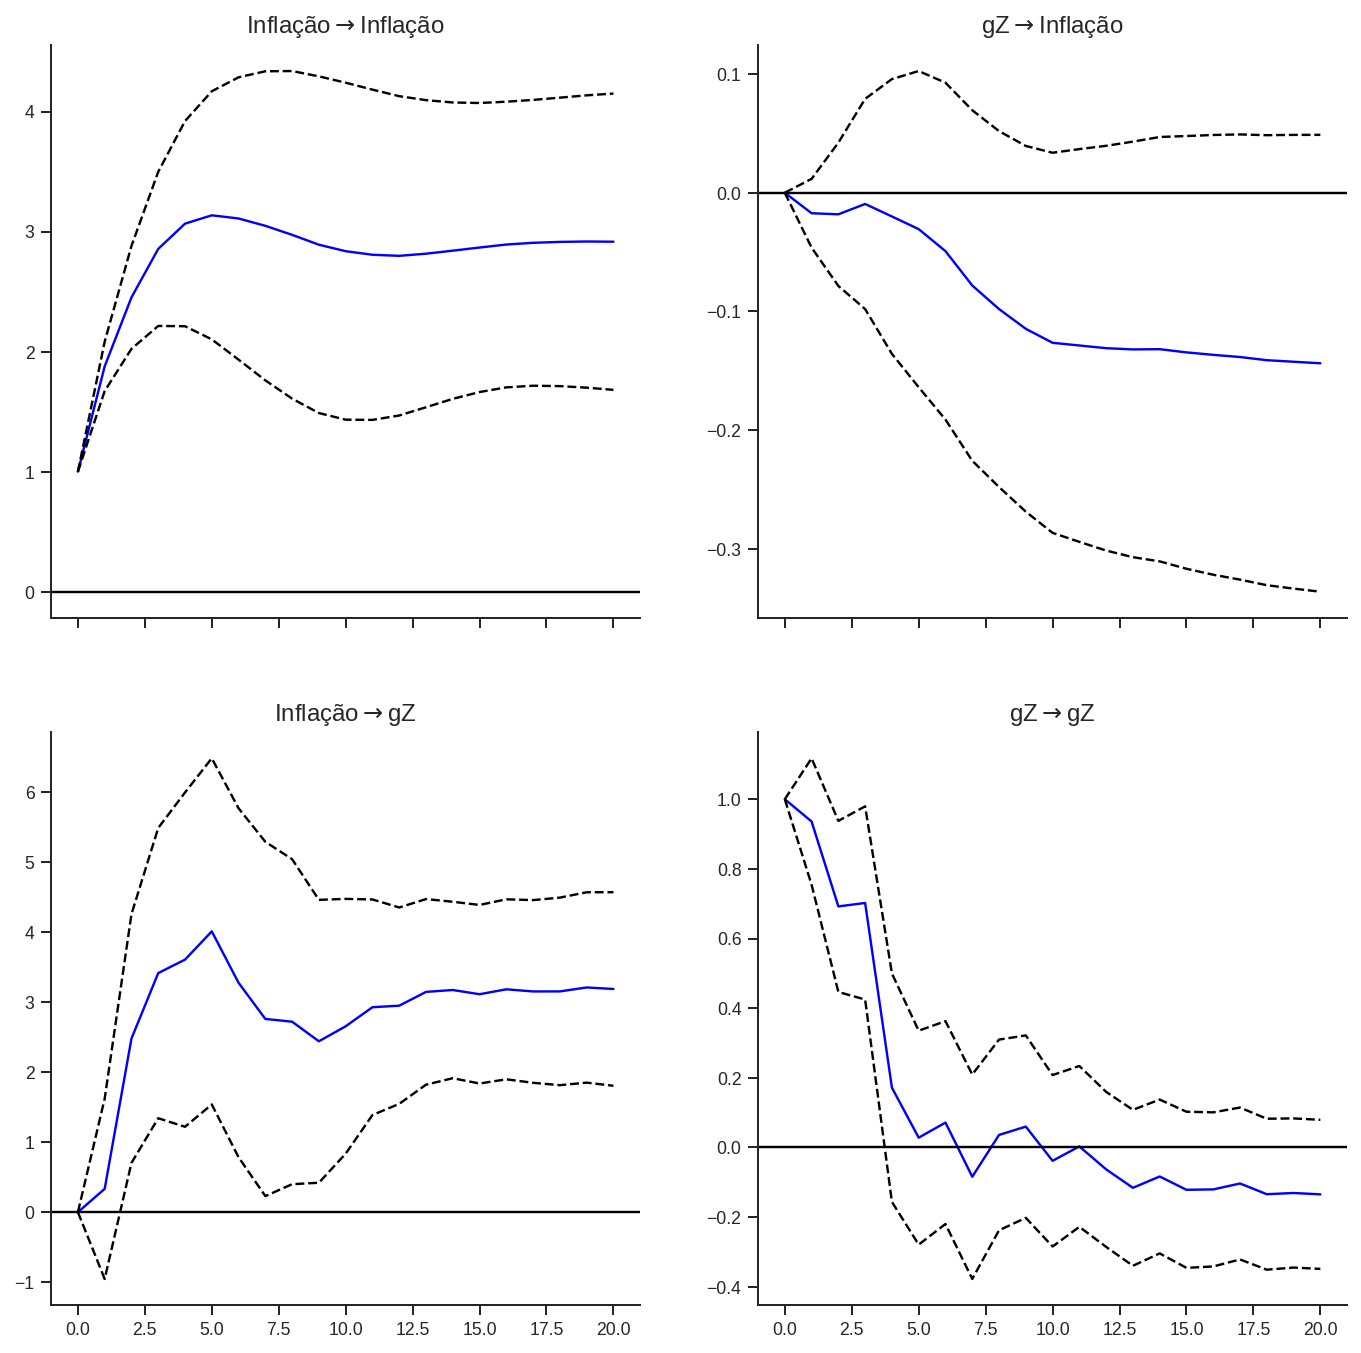

In [23]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM_Infla_Infla.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# Teste de causalidade de granger

In [24]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Inflação does not Granger-cause gZ. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.999          2.265   0.081 (5, 178)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Inflação does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         15.85          3.841   0.000  1
----------------------------------------


## Inspeção gráfica dos resíduos

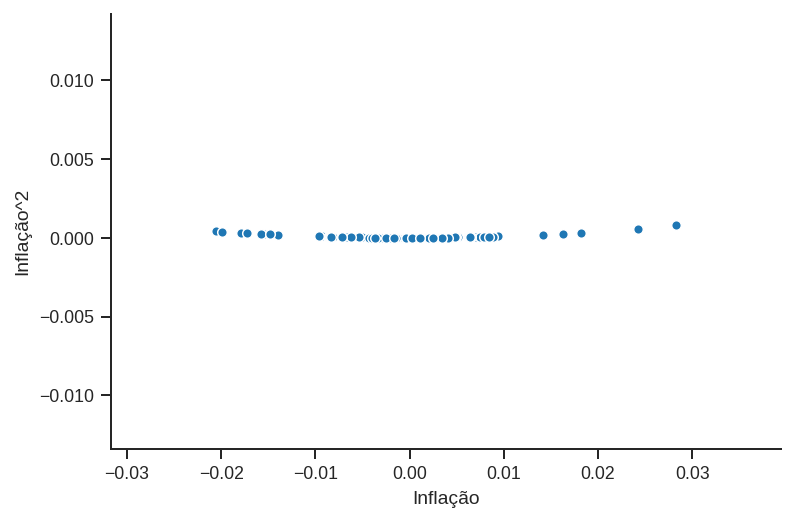

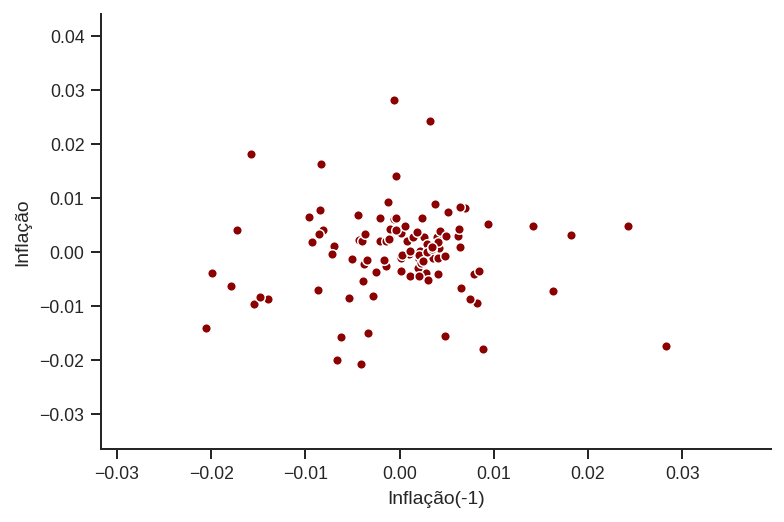

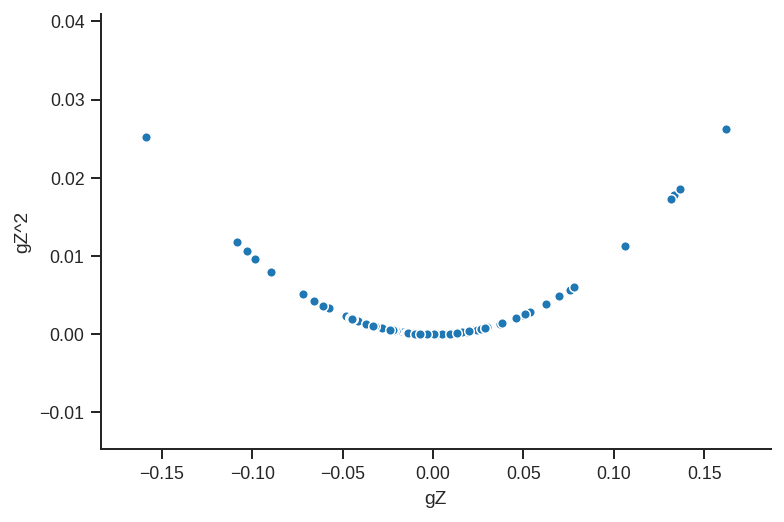

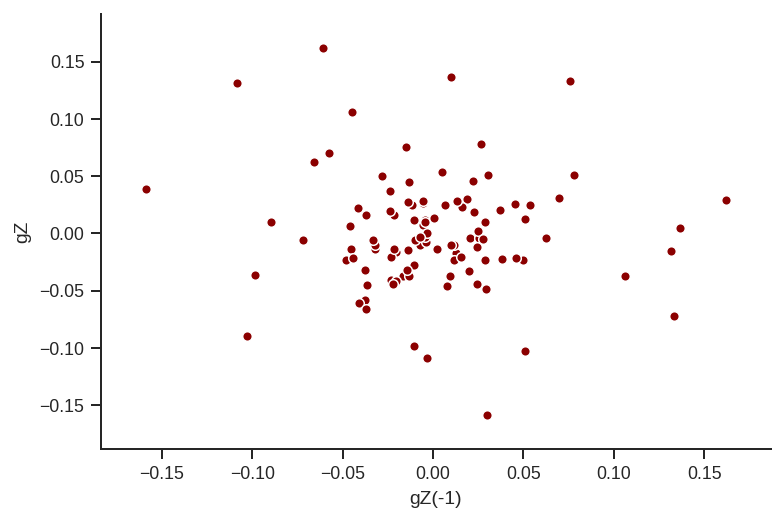

In [25]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

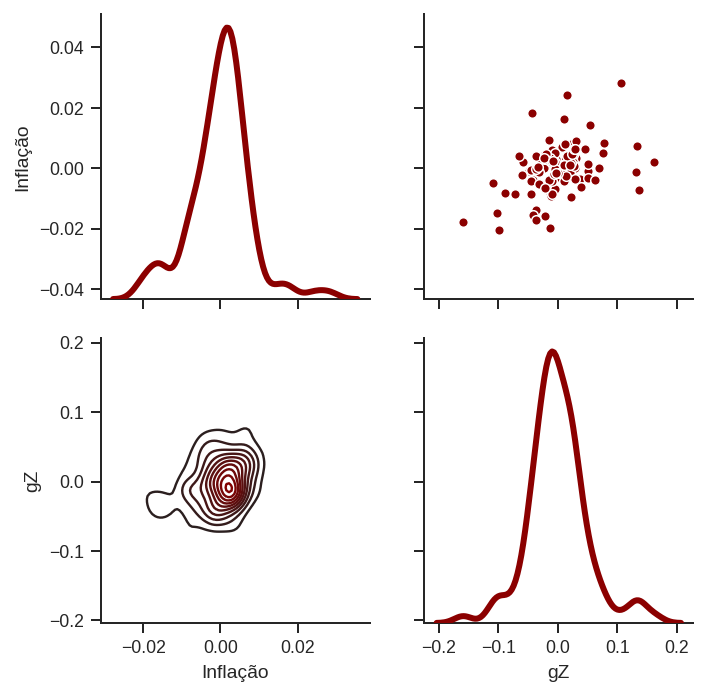

In [26]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM_Infla_Infla.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

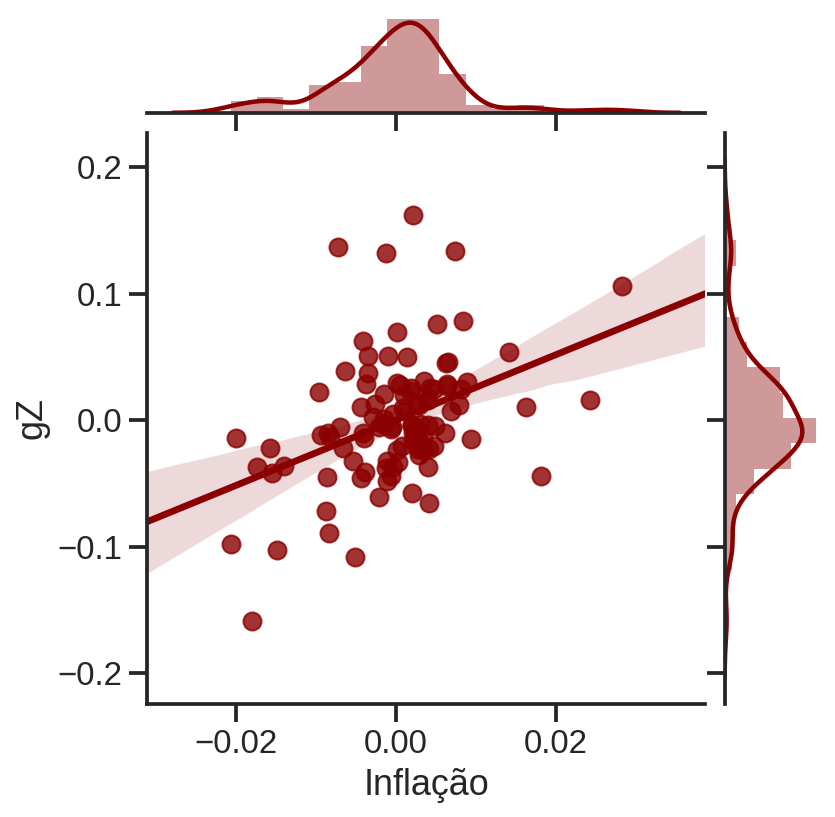

In [27]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

## FEVD

ATENÇÃO!!!!

In [28]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- na.omit(df[,c("Juros", "Infla","TaxaP", "gZ")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("Infla","gZ")], lag = 4, r = 1, estim = "ML", LRinclude="both", include="trend", exogen = coredata(df[,"Juros"]))
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [29]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$Infla)

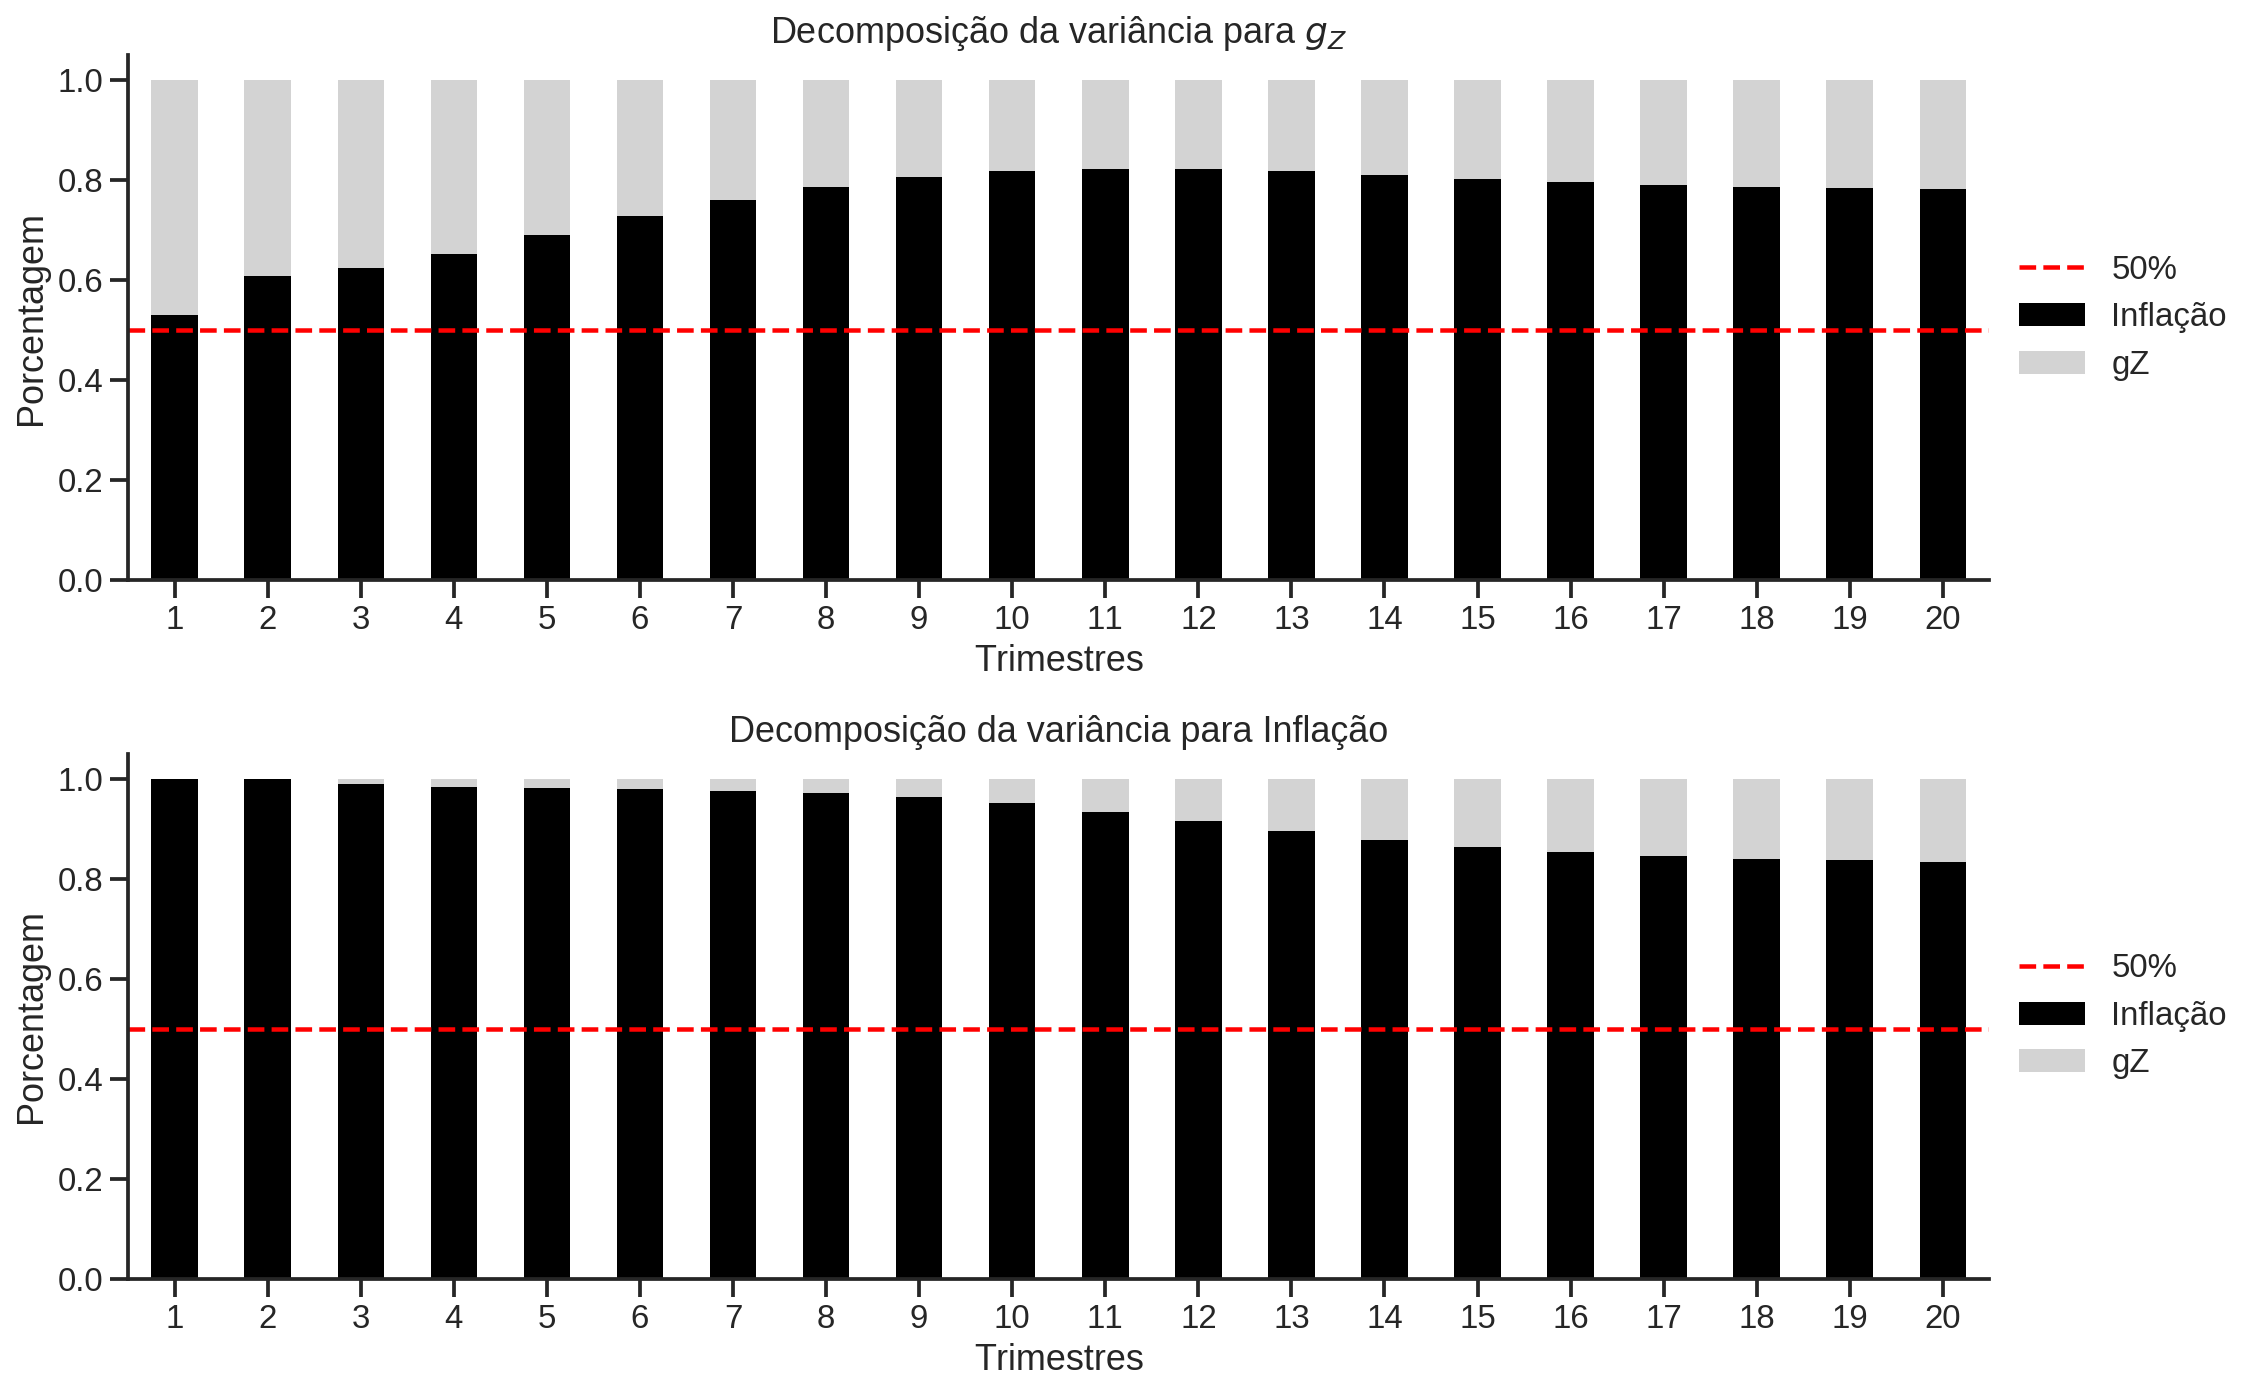

In [30]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Inflação", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM_Infla_Infla.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [31]:
model = VAR(
    df[["d_Inflação", 'd_gZ']],
    exog=df['Taxa de juros']
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.41      -14.25   5.492e-07      -14.35
1       -15.07     -14.80*   2.846e-07      -14.96
2       -15.06      -14.69   2.871e-07      -14.91
3       -15.06      -14.57   2.889e-07      -14.86
4      -15.27*      -14.68  2.348e-07*     -15.03*
5       -15.24      -14.54   2.414e-07      -14.96
6       -15.18      -14.37   2.577e-07      -14.85
7       -15.16      -14.25   2.625e-07      -14.79
8       -15.12      -14.10   2.741e-07      -14.71
9       -15.12      -13.99   2.766e-07      -14.66
10      -15.06      -13.82   2.952e-07      -14.56
11      -15.00      -13.66   3.140e-07      -14.46
12      -15.09      -13.64   2.875e-07      -14.51
13      -15.04      -13.48   3.068e-07      -14.41
14      -14.97      -13.30   3.308e-07      -14.30
15      -15.04      -13.26   3.134e-07      -14.32
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [32]:
results = model.fit(maxlags=4)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 17, dez, 2019
Time:                     09:00:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.8442
Nobs:                     106.000    HQIC:                  -15.1431
Log likelihood:           532.563    FPE:                2.16510e-07
AIC:                     -15.3468    Det(Omega_mle):     1.80790e-07
--------------------------------------------------------------------
Results for equation d_Inflação
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.001955         0.003203            0.610           0.542
exog0                -0.031260         0.053044           -0.589           0.556
L1.d_Inflação         0.871414         0.110806        

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

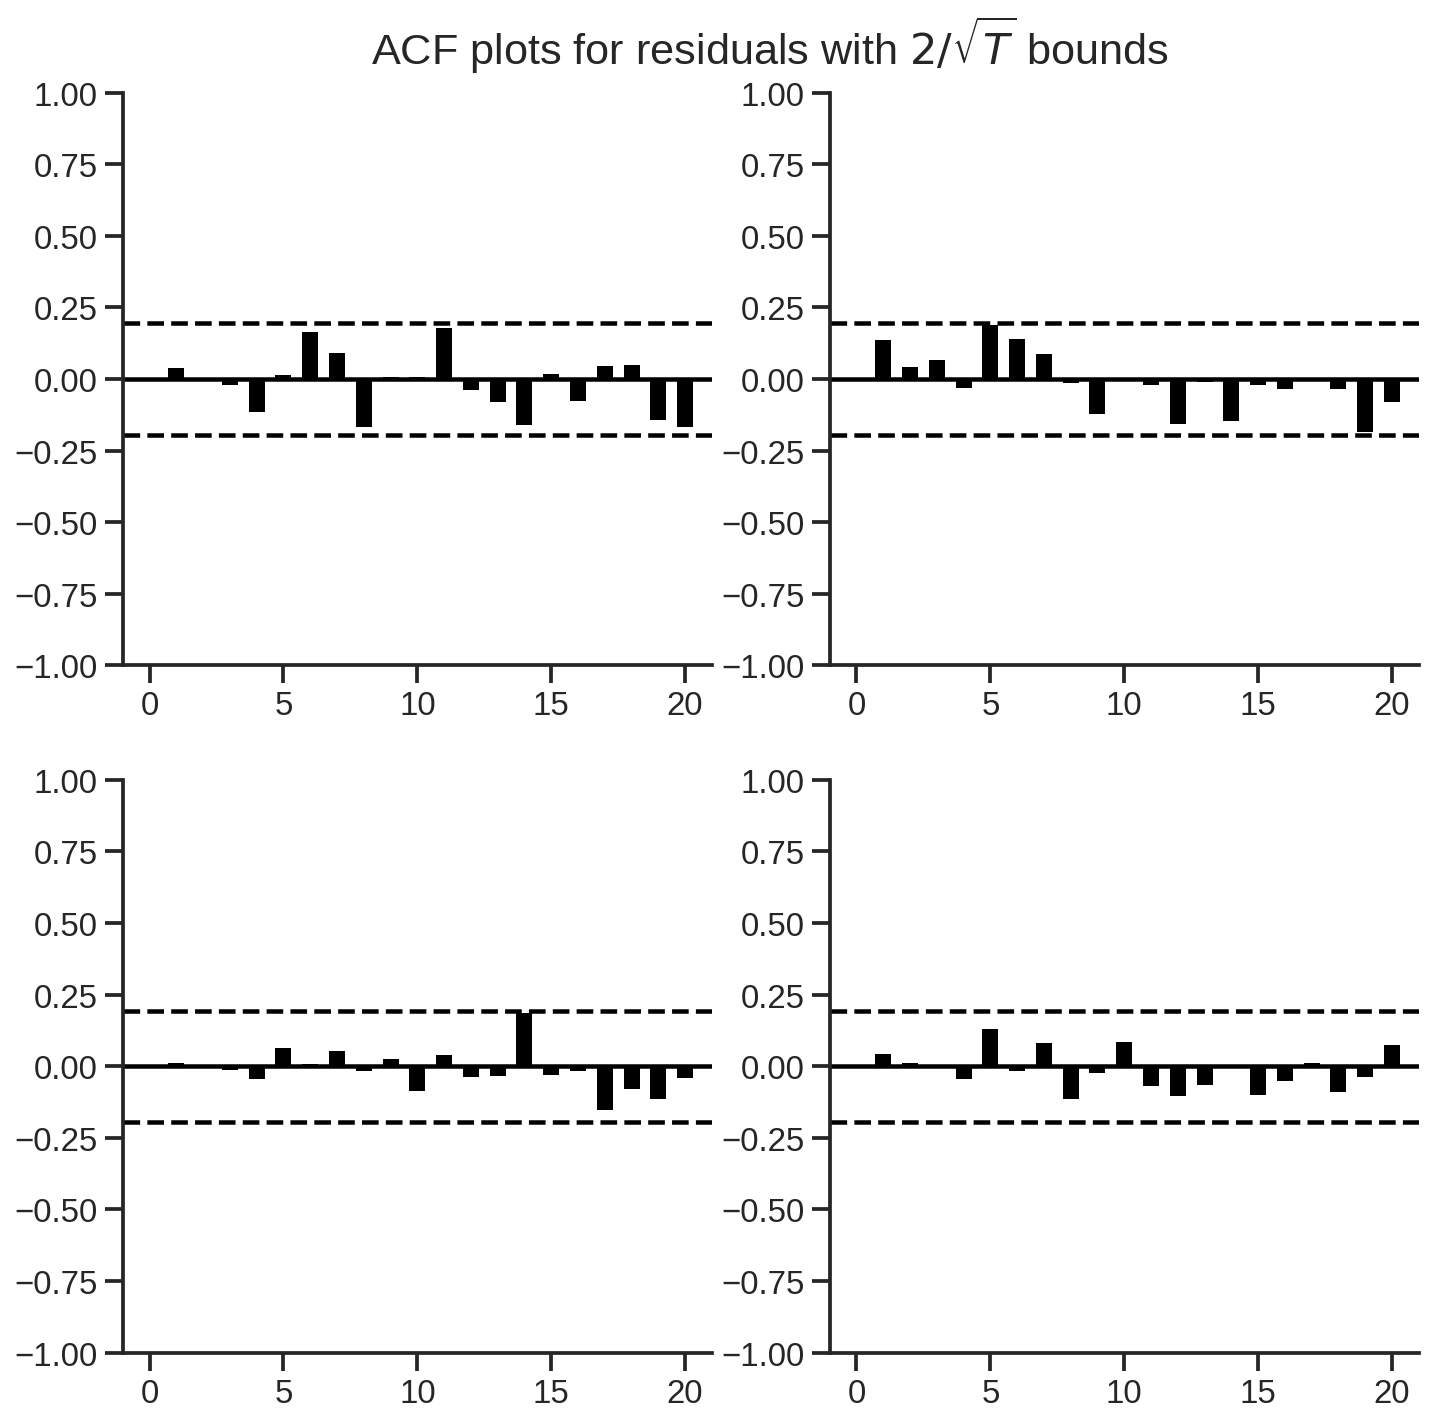

In [33]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [34]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.7906695184506395
0.7906695184506395
0.7979794749937019
0.7979794749937019
0.8354279097004361
0.8354279097004361
0.5244253798557569
0.5244253798557569
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

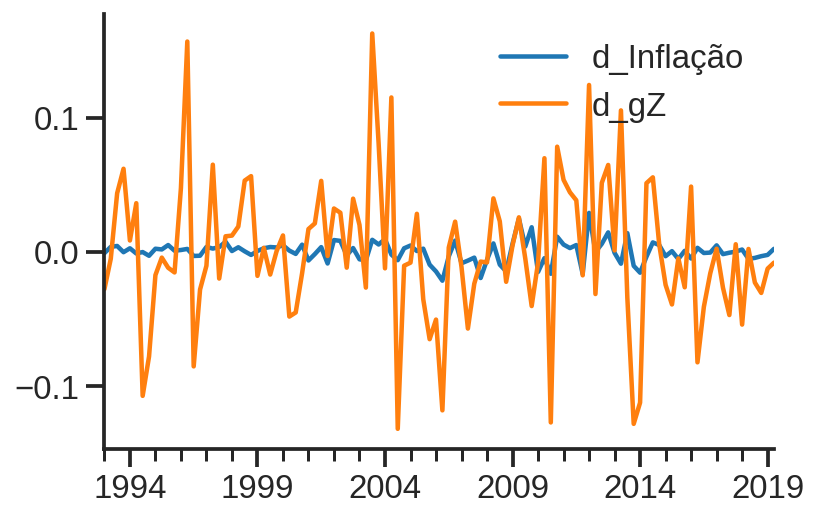

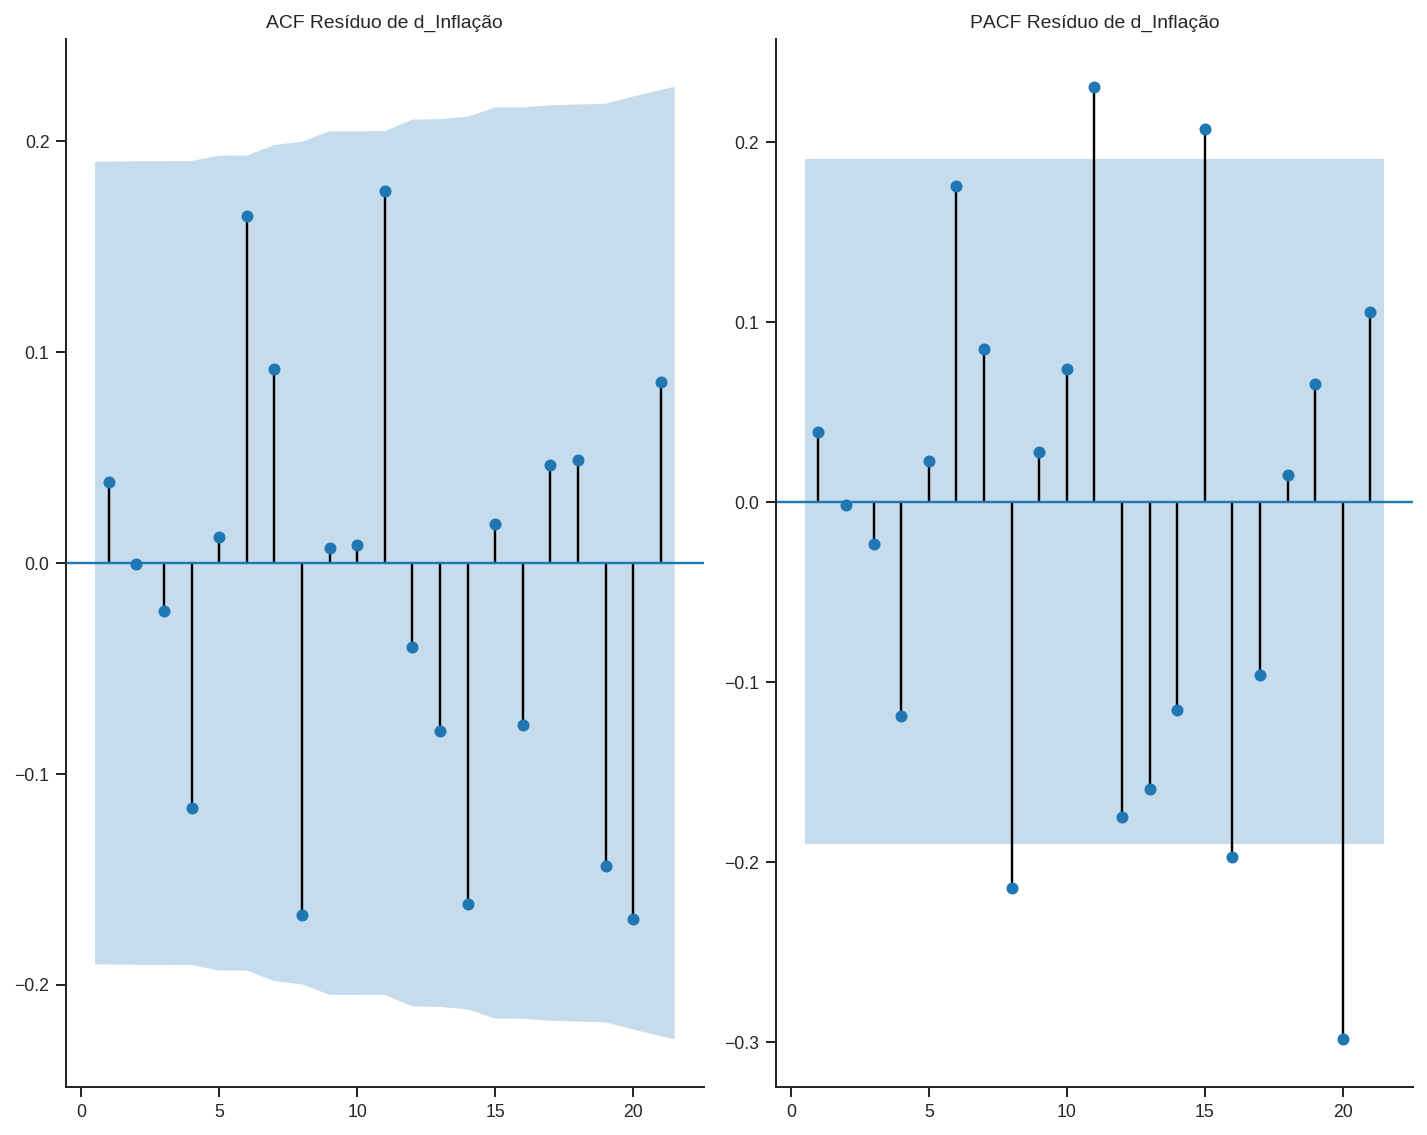

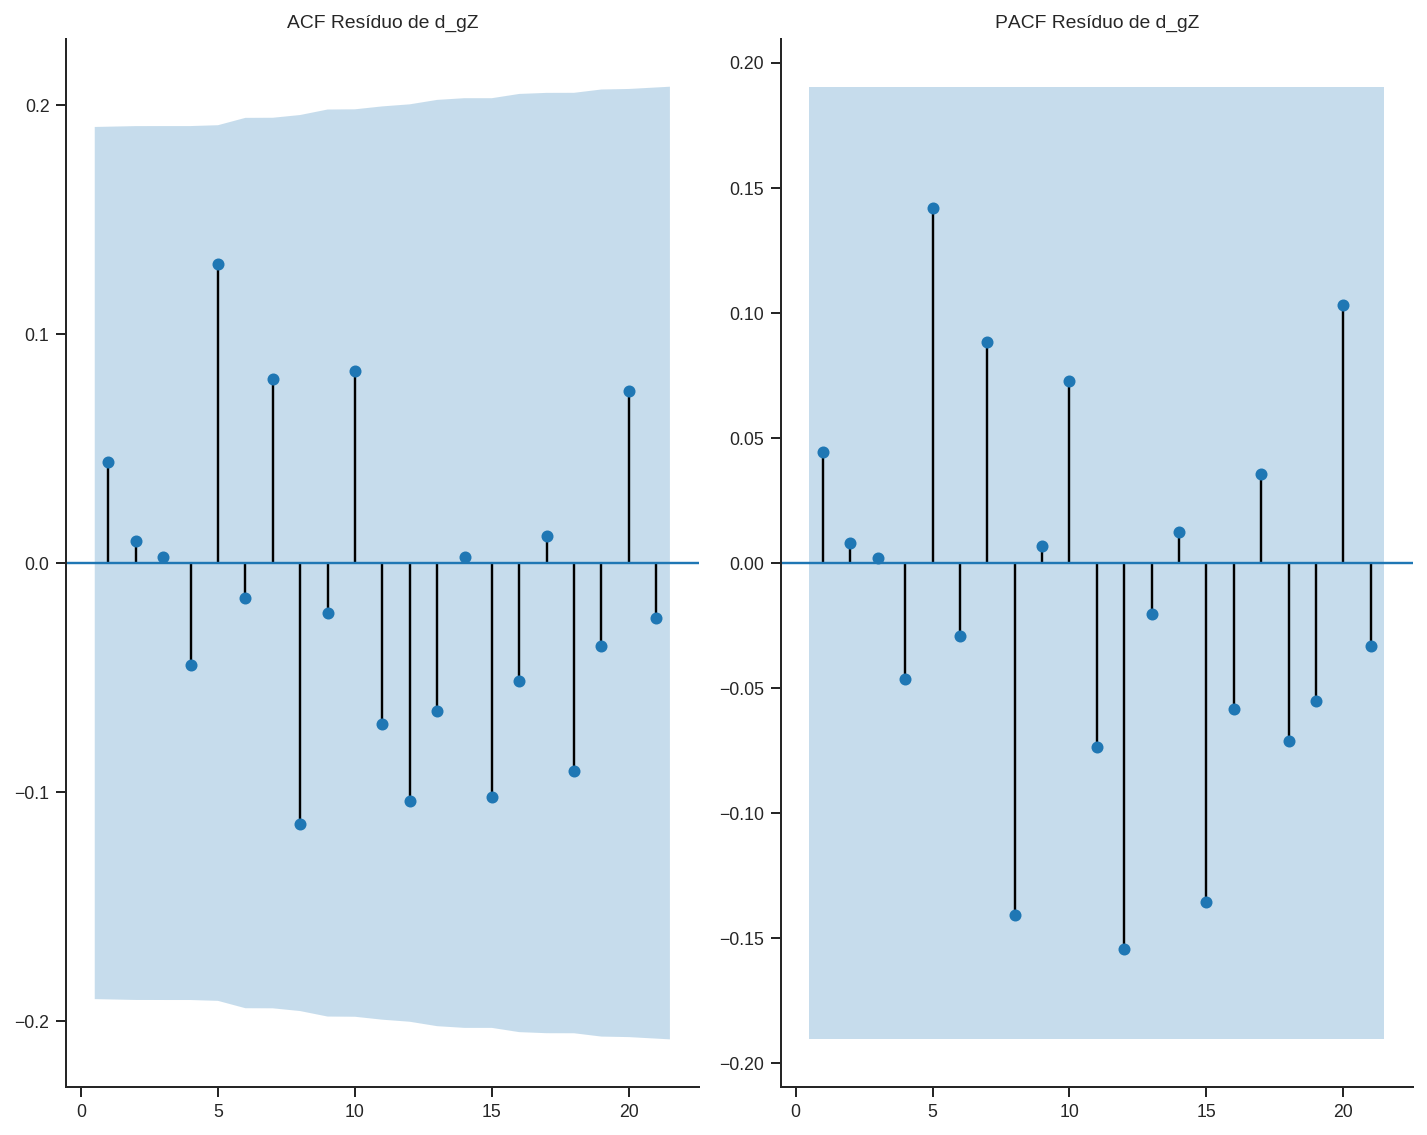

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         50.65          60.48   0.228 44
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         55.70          60.48   0.111 44
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  

In [35]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

In [ ]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

In [ ]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

In [ ]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

In [ ]:
plot_lags(results=results)

## Função resposta ao impulso ortogonalizada

In [ ]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Função resposta ao impulso não-ortogonalizada

In [ ]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

In [ ]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

In [ ]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)